# Purpose
To find indicators of fighter styles so that we can indicate what a fighter's strengths are. We will examine the distributions of the various metrics used in the current data set to see if there is any connection between any of the metrics and any particular fighting style. These styles include Wrestling, Brazilian Jiu Jitsu/Submission Grappling, Striking, and possibly Boxing, and Muay Thai.

In [103]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
    
import pandas as pd
from sqlalchemy import create_engine
from src import local
from src import functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load the data

In [2]:
# Set up tables
# Credentials
USER = local.user 
PASS = local.password
HOST = local.host
PORT = local.port

#create engine
engine = create_engine(f'postgresql://{USER}:{PASS}@{HOST}:{PORT}/match_finder')

### Striking
#### Objectives
1. investigate top and bottom performers
2. 

In [14]:
query = """
SELECT *
FROM striking_adv
JOIN bouts ON bouts.id = striking_adv.bout_id
JOIN events ON events.id = bouts.event_id
"""

striking = pd.read_sql(query, engine)

In [17]:
striking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25772 entries, 0 to 25771
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bout_id       25772 non-null  object 
 1   fighter_id    25772 non-null  object 
 2   round         25772 non-null  object 
 3   fighter       25772 non-null  object 
 4   ss_s          25772 non-null  int64  
 5   ss_s_pr_di    25772 non-null  int64  
 6   ss_s_p15m     25772 non-null  float64
 7   ss_s_p15m_di  25772 non-null  float64
 8   ss_a          25772 non-null  int64  
 9   ss_a_pr_di    25772 non-null  int64  
 10  ss_a_p15m     25772 non-null  float64
 11  ss_a_p15m_di  25772 non-null  float64
 12  ts_s          25772 non-null  int64  
 13  ts_s_pr_di    25772 non-null  int64  
 14  ts_s_p15m     25772 non-null  float64
 15  ts_s_p15m_di  25772 non-null  float64
 16  ts_a          25772 non-null  int64  
 17  ts_a_pr_di    25772 non-null  int64  
 18  ts_a_p15m     25772 non-nu

In [29]:
striking = striking[striking['fighter_id']!='no_link']

In [30]:
striking['date'] = pd.to_datetime(striking['date'])

<ipython-input-30-788d2dfb1028>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  striking['date'] = pd.to_datetime(striking['date'])


##### Group by fighter_id

In [31]:
striking_groupby = striking.groupby('fighter_id')

In [32]:
names = striking_groupby.fighter.max()

In [48]:
number_of_fights = striking_groupby.bout_id.unique().map(lambda x: len(x))

In [54]:
list(striking.columns)

['bout_id',
 'fighter_id',
 'round',
 'fighter',
 'ss_s',
 'ss_s_pr_di',
 'ss_s_p15m',
 'ss_s_p15m_di',
 'ss_a',
 'ss_a_pr_di',
 'ss_a_p15m',
 'ss_a_p15m_di',
 'ts_s',
 'ts_s_pr_di',
 'ts_s_p15m',
 'ts_s_p15m_di',
 'ts_a',
 'ts_a_pr_di',
 'ts_a_p15m',
 'ts_a_p15m_di',
 'kd',
 'kd_pr_di',
 'kd_p15m',
 'kd_p15m_di',
 'method',
 'final_round',
 'time',
 'timeformat',
 'referee',
 'details',
 'id',
 'event_id',
 'date',
 'location',
 'attendance',
 'name',
 'id']

In [67]:
stats = ['ss_s',
'ss_s_pr_di',
'ss_s_p15m',
'ss_s_p15m_di',
'ss_a',
'ss_a_pr_di',
'ss_a_p15m',
'ss_a_p15m_di',
'ts_s',
'ts_s_pr_di',
'ts_s_p15m',
'ts_s_p15m_di',
'ts_a',
'ts_a_pr_di',
'ts_a_p15m',
'ts_a_p15m_di',
'kd',
'kd_pr_di',
'kd_p15m',
'kd_p15m_di']

In [68]:
stat_dict={}
for stat in stats:
    stat_dict[stat] = striking_groupby[stat].mean()

In [69]:
stat_dict['matches'] = number_of_fights
stat_dict['name'] = names

In [70]:
striking_by_fighter = pd.DataFrame(stat_dict)

In [83]:
striking_by_fighter = striking_by_fighter[striking_by_fighter['matches']>=3]

### Knockdowns

Per 15 minutes

In [84]:
striking_by_fighter.loc[
    :,['kd_p15m_di', 'name']
].sort_values(
    'kd_p15m_di', ascending=False
).iloc[:10]

,kd_p15m_di,name
fighter_id,,
9ccdd2ce45903f34,23.275862,Mark Weir
bda04c573563cc2e,18.583838,Todd Duffee
a7f4d0902bb64092,15.893056,James Irvin
4123fd4dcc1fe937,12.500000,David Terrell
c21f26bbde777573,12.229385,Jr. Johnny Walker
2cd428e9606856fd,10.574169,Jairzinho Rozenstruik
bc3ec52ef70fc155,9.196148,Ryan Jimmo
84ac950d4c1722dd,8.942909,Duane Ludwig
0d65c432720accb9,8.867263,Michal Oleksiejczuk


In [85]:
striking_by_fighter.loc[
    :,['kd_p15m', 'name']
].sort_values(
    'kd_p15m', ascending=False
).iloc[:10]

,kd_p15m,name
fighter_id,,
9ccdd2ce45903f34,23.275862,Mark Weir
bda04c573563cc2e,20.850741,Todd Duffee
a7f4d0902bb64092,18.189103,James Irvin
2cd428e9606856fd,15.074169,Jairzinho Rozenstruik
c21f26bbde777573,13.241758,Jr. Johnny Walker
4123fd4dcc1fe937,12.500000,David Terrell
84ac950d4c1722dd,10.000000,Duane Ludwig
1fd4fbdcc67de844,9.645893,Drew McFedries
bc3ec52ef70fc155,9.196148,Ryan Jimmo


### Significant Strikes
#### Successes

In [86]:
striking_by_fighter.loc[
    :,['ss_s_p15m', 'name']
].sort_values(
    'ss_s_p15m', ascending=False
).iloc[:10]

,ss_s_p15m,name
fighter_id,,
8bdac25ce0bb874d,170.907001,Ronda Rousey
bda04c573563cc2e,158.692193,Todd Duffee
2e5c2aa8e4ab9d82,150.689410,Paulo Costa
32490e80ddab1e5a,140.591729,Kenan Song
f14cf73e51b29254,138.016783,Sergei Pavlovich
1ebe20ebbfa15e29,132.283576,Weili Zhang
b59037262c8fe060,128.861996,Ryan Janes
207773daeb4afa7b,126.893187,Devonte Smith
2cd428e9606856fd,124.169043,Jairzinho Rozenstruik


In [87]:
striking_by_fighter.loc[
    :,['ss_s_p15m_di', 'name']
].sort_values(
    'ss_s_p15m_di', ascending=False
).iloc[:10]

,ss_s_p15m_di,name
fighter_id,,
bda04c573563cc2e,106.805038,Todd Duffee
9ccdd2ce45903f34,83.785400,Mark Weir
01b39decaf0abf6a,82.969792,Benji Radach
4144798612ef96e5,79.676244,Edmen Shahbazyan
32490e80ddab1e5a,78.775940,Kenan Song
207773daeb4afa7b,74.812794,Devonte Smith
634bb0de2eb043b4,74.296909,Cristiane Justino
f14cf73e51b29254,71.681543,Sergei Pavlovich
85073dbd1be65ed9,66.454608,Greg Hardy


#### Attempts

In [88]:
striking_by_fighter.loc[
    :,['ss_a_p15m', 'name']
].sort_values(
    'ss_a_p15m', ascending=False
).iloc[:10]

,ss_a_p15m,name
fighter_id,,
bda04c573563cc2e,308.291229,Todd Duffee
9c44f290f5726d95,281.268275,Martin Bravo
76984112f697631f,279.681214,Leslie Smith
8bdac25ce0bb874d,274.748005,Ronda Rousey
1ebe20ebbfa15e29,252.498831,Weili Zhang
b59037262c8fe060,252.469919,Ryan Janes
2e5c2aa8e4ab9d82,252.023052,Paulo Costa
edd02825c29028fe,250.373289,Marco Polo Reyes
f14cf73e51b29254,239.696252,Sergei Pavlovich


In [89]:
striking_by_fighter.loc[
    :,['ss_a_p15m_di', 'name']
].sort_values(
    'ss_a_p15m_di', ascending=False
).iloc[:10]

,ss_a_p15m_di,name
fighter_id,,
bda04c573563cc2e,168.113135,Todd Duffee
cd13728ae1151f46,126.886260,Ion Cutelaba
daf1b84aebd6602b,114.379105,Roger Huerta
c451d67c09c55418,105.158883,Chan Sung Jung
9ccdd2ce45903f34,103.309061,Mark Weir
1ebe20ebbfa15e29,103.190244,Weili Zhang
f53d4f21d1b5f2dc,101.047358,Diego Ferreira
c5a126ace82a6025,98.593457,Anthony Birchak
01b39decaf0abf6a,96.497917,Benji Radach


### grappling
#### Objectives

In [96]:
query = """
SELECT *
FROM grappling_adv
JOIN bouts ON bouts.id = grappling_adv.bout_id
JOIN events ON events.id = bouts.event_id
"""

grappling = pd.read_sql(query, engine)

grappling.info()

grappling = grappling[grappling['fighter_id']!='no_link']

grappling['date'] = pd.to_datetime(grappling['date'])

##### Group by fighter_id

grappling_groupby = grappling.groupby('fighter_id')

names = grappling_groupby.fighter.max()

number_of_fights = grappling_groupby.bout_id.unique().map(lambda x: len(x))

list(grappling.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25772 entries, 0 to 25771
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bout_id       25772 non-null  object 
 1   fighter_id    25772 non-null  object 
 2   round         25772 non-null  object 
 3   fighter       25772 non-null  object 
 4   td_s          25772 non-null  int64  
 5   td_s_pr_di    25772 non-null  int64  
 6   td_s_p15m     25772 non-null  float64
 7   td_s_p15m_di  25772 non-null  float64
 8   td_a          25772 non-null  int64  
 9   td_a_pr_di    25772 non-null  int64  
 10  td_a_p15m     25772 non-null  float64
 11  td_a_p15m_di  25772 non-null  float64
 12  sba           25772 non-null  int64  
 13  sba_pr_di     25772 non-null  int64  
 14  sba_p15m      25772 non-null  float64
 15  sba_p15m_di   25772 non-null  float64
 16  rev           25772 non-null  int64  
 17  rev_pr_di     25772 non-null  int64  
 18  rev_p15m      25772 non-nu

['bout_id',
 'fighter_id',
 'round',
 'fighter',
 'td_s',
 'td_s_pr_di',
 'td_s_p15m',
 'td_s_p15m_di',
 'td_a',
 'td_a_pr_di',
 'td_a_p15m',
 'td_a_p15m_di',
 'sba',
 'sba_pr_di',
 'sba_p15m',
 'sba_p15m_di',
 'rev',
 'rev_pr_di',
 'rev_p15m',
 'rev_p15m_di',
 'ps',
 'ps_pr_di',
 'ps_p15m',
 'ps_p15m_di',
 'method',
 'final_round',
 'time',
 'timeformat',
 'referee',
 'details',
 'id',
 'event_id',
 'date',
 'location',
 'attendance',
 'name',
 'id']

In [99]:
stats = ['td_s',
 'td_s_pr_di',
 'td_s_p15m',
 'td_s_p15m_di',
 'td_a',
 'td_a_pr_di',
 'td_a_p15m',
 'td_a_p15m_di',
 'sba',
 'sba_pr_di',
 'sba_p15m',
 'sba_p15m_di',
 'rev',
 'rev_pr_di',
 'rev_p15m',
 'rev_p15m_di',
 'ps',
 'ps_pr_di',
 'ps_p15m',
 'ps_p15m_di',]

stat_dict={}
for stat in stats:
    stat_dict[stat] = grappling_groupby[stat].mean()

stat_dict['matches'] = number_of_fights
stat_dict['name'] = names

grappling_by_fighter = pd.DataFrame(stat_dict)

grappling_by_fighter = grappling_by_fighter[grappling_by_fighter['matches']>=5]

### Submission Attempts

In [105]:
grappling_by_fighter.loc[
    :,['sba_p15m', 'name']
].sort_values(
    'sba_p15m', ascending=False
).iloc[:20]

,sba_p15m,name
fighter_id,,
7b143a54451263d9,8.345865,Paul Sass
8bdac25ce0bb874d,8.083377,Ronda Rousey
8ddf9c51c5fdea75,7.280234,Rousimar Palhares
8f2939f5fd9cca1e,7.020650,TJ Waldburger
7bd94b60d7521e4a,5.939611,John Albert
2dc1bc1a02961656,5.894092,Manny Bermudez
d468288756ae3982,4.920935,Renato Sobral
263ebd4a669e1e98,4.904762,Fabiano Iha
07225ba28ae309b6,4.885077,Charles Oliveira


In [106]:
grappling_by_fighter.loc[
    :,['sba_p15m_di', 'name']
].sort_values(
    'sba_p15m_di', ascending=False
).iloc[:20]

,sba_p15m_di,name
fighter_id,,
8bdac25ce0bb874d,7.800269,Ronda Rousey
7b143a54451263d9,7.218045,Paul Sass
8ddf9c51c5fdea75,6.291708,Rousimar Palhares
8f2939f5fd9cca1e,5.315116,TJ Waldburger
d468288756ae3982,4.920935,Renato Sobral
2dc1bc1a02961656,4.841381,Manny Bermudez
263ebd4a669e1e98,4.604762,Fabiano Iha
04643fd03d9159cc,4.446429,Marcus Aurelio
9e50097a89442158,4.217270,Mickey Gall


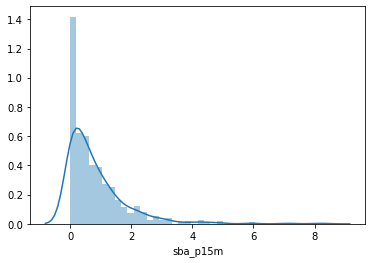

In [107]:
sns.distplot(grappling_by_fighter.sba_p15m)

Reversals

In [109]:
grappling_by_fighter.loc[
    :,['ps_p15m', 'name']
].sort_values(
    'ps_p15m', ascending=False
).iloc[:20]

,ps_p15m,name
fighter_id,,
84ff027394f7e470,13.220946,Moreira Gregor Gillespie
b08012bbe542592a,10.066494,Tatiana Suarez
38c7f72747f4f712,8.342862,Silva Gillian Robertson
2dc1bc1a02961656,7.885261,Manny Bermudez
daf1b84aebd6602b,7.509704,Roger Huerta
8bdac25ce0bb874d,6.781142,Ronda Rousey
d4691518d012b9e7,6.740637,Randamie Aspen Ladd
6f7c616b98e18c29,6.644599,Claudio Silva
67f272324a030d00,6.529866,Misha Cirkunov


In [110]:
grappling_by_fighter.loc[
    :,['ps_p15m_di', 'name']
].sort_values(
    'ps_p15m_di', ascending=False
).iloc[:20]

,ps_p15m_di,name
fighter_id,,
84ff027394f7e470,13.220946,Moreira Gregor Gillespie
b08012bbe542592a,10.066494,Tatiana Suarez
38c7f72747f4f712,8.092862,Silva Gillian Robertson
8bdac25ce0bb874d,6.498034,Ronda Rousey
d4691518d012b9e7,6.140637,Randamie Aspen Ladd
6f7c616b98e18c29,5.578009,Claudio Silva
032cc3922d871c7f,5.429699,Khabib Nurmagomedov
893d51aaf024eddd,5.357632,Jimy Hettes
67f272324a030d00,5.107617,Misha Cirkunov
